<center> 

# Assignment 1 - Evolutionary process discovery
</center>

## Processes and Petri Nets
The financial institute PETRINAS manages loan requests from its customers according to a not well-formalized process model. The process starts when a request is received. Then, the request passes preliminary assessments, aimed at verifying whether the applicant meets the requirements. The request also undergoes frauds detection. As soon as an application is not eligible, the process is terminated. The user receives an offer and can communicate whether he/she intends to accept it. If this is not the case, the process ends. Otherwise, a contract is drawn and finally sent to the customer. The actual sequence of these actions is unknown to the institute.

A sequence of actions can be formalized and investigated using a Petri Net (PN). A PN is a directed bipartite graph characterized by two sets of nodes: the places (used to represent the status of the process) and the transitions (corresponding to the activities described above) connecting the places. Places can only be connected to transitions, and transitions can only be connected to places.

PNs can be effective to represent and study processes. For example, the PN shown in Fig. 1 represents one possible action: receiving the request, a transition which brings from place p1 to place p2.


<center>

![image.png](attachment:image.png)

**Fig. 1** - Example of Petri net with two places and one transitions

</center>

Given a set of $𝑀$ places and a set of $𝑁$ transitions, we can represent the PN’s connections using a matrix $𝐴$ of dimension $𝑀 \times 𝑁$.
The $𝑚$-th row in the matrix denotes the 𝑚-th place. The 𝑛-th column represents the 𝑛-th transition. Then, the element $𝑎_{𝑚,𝑛}$ of the matrix encodes the connection between the $𝑚$-th place and the $𝑛$-th transition.

- if $a_{m,n}=-1$ then an arc connects the $m$-th place to the $n$-th transition;
- if $a_{m,n}= 1$ then an arc connects the $n$-th transition to the $m$-th place;

As an example, consider the PN in Fig. 2.

<center>

![image-2.png](attachment:image-2.png)

**Fig. 2** - Example of Petri net with three places and two transitions

</center>

The PN in Fig. 2 can be represented by the following $3\times 2$ matrix:

$$\begin{matrix}
  -1&0\\
   1&-1\\
   0&1
\end{matrix}
$$

Given a PN encoded as a matrix, we can perform a simulation of a process by starting from an arbitrary place (we will use p1 as default) and “follow the arcs”. If we keep track of the transitions (i.e., activities) followed during the simulation we get a simulated **trace**. For instance, the PN in Fig. 2 can produce the following trace:

<center>“Receiving request”, “Fraud check”</center>

The company PETRINAS has collected a dataset composed of 100 traces of this kind from their processes (contained in the file ```dataset_a2.txt``` ) and is
now interested in creating and investigating the associated PN. The company knows that there are 10 clear activities + 2 “invisible activities” in their process, which corresponds to an unknown matrix with dimension $12\times 12$ to be discovered. Considering that each element of the matrix can take values {-1, 0, 1} then the number of possible PNs to be tested is $3^{144} \approx 5 × 10^{68}$ which is clearly not feasible by means of an exhaustive search.


## Genetic Algorithms to the rescue
We can explore this huge search space using a **Genetic Algorithm** (GA). The candidate solutions (i.e., the PN matrices) can be encoded as **linearized lists of integer numbers**. For instance, the PN in Fig. 2 can be encoded as: [-1, 0, 1, -1, 0, 1].

A very simple fitness function for a candidate solution can be based on the **simulation** of the experimental traces. Specifically, given a candidate PN whose fitness value must be assessed, we can iterate on each trace of the dataset and see whether the PN can actually simulate that trace correctly. For each correct step taken the PN in a trace, we accumulate +1 in a counter. As soon as the simulation is blocked (because we cannot take the next expected transition from the place that we reached in the PN), the simulation of that trace terminates and we start over with the following trace. When no more traces can be simulated, the counter is returned as the fitness value for that PN.

The pseudocode of the aforementioned fitness function is shown below:

```
def fitness(A):
    counter = 0
    for trace in dataset:
        current_place = p1
        for activity in trace:
            if A[current_place][activity] == -1:
                counter += 1
                current_place = get_new_place(A, activity)
            else: 
                break
    return counter
```

If we try to optimize this fitness function, we find out that the GA tend to converge to a complex PN with several arcs. In order to mitigate this phenomenon, we can introduce a penalty factor in the formula. For instance, we can penalize the number arcs in the PN, in order to promote smaller solutions (see, e.g., De Medeiros et al., “Using Genetic Algorithms to Mine Process Models”). To do so, we can change the last line of the function as follows:

```
return w*counter - (1-w)*count_nonzero(A)
```

where ```count_nonzero()``` is a function that returns the total number of elements in A that are not equal to 0. By using this approach, PNs with a lot of arcs get penalized. In the equation, the contribution of the correct traces and the regularization terms is balanced with a real parameter w in [0,1]. The greater the value, the higher the contribution of the traces to the final fitness value. You can find this fitness function and the simulation code already implemented in the ```support.py``` file on Canvas (in this assignment, we set w=0.9).


In [6]:
# Importing stuffs
!pip install deap

import numpy as np
from matplotlib.pyplot import * 
import operator
import random
import matplotlib.pyplot as plt
import pandas as pd
from deap import base, creator, tools, algorithms
from google.colab import files
uploaded = files.upload()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving dataset_a1.txt to dataset_a1.txt


In [21]:
# Calling the Data-set

transitions = [ "Receiving Request", "First Assessment", "Fraud Check",  "Invisible 2", "Invisible 1",
"Accept", "Decline", "Create Offer", "Contact Customer", 
"Offer Refused", "Draw Contract", "Send Contract", ]
names_to_transition = dict(zip(transitions, range(len(transitions))))

PLACES = 12
TRANSITIONS = 12

# helper conversion list to numpy array
def list_to_array(sol): return np.array(sol).reshape((PLACES, TRANSITIONS))

# loads and prepares the dataset for fitness evaluations
def load_dataset(path):
	res = []
	with open(path) as fi:
		for line in fi:
			res.append(line.strip().split(", "))
	return res


dataset = load_dataset("dataset_a1.txt")


# Converting the dataset into numerics from names_to_transition
dataset_numeric = []
for i in range(0,100):
	# List comprehension conversion and appending it to the empty dataset_numeric list
	dataset_numeric.append([names_to_transition[dataset[i][j]] for j in range(0, len(dataset[i]))])

dataset_numeric

[[0, 1, 2, 6],
 [0, 1, 2, 2, 2, 6],
 [0, 1, 2, 6],
 [0, 1, 2, 2, 5, 7, 8, 9],
 [0, 1, 2, 6],
 [0, 1, 2, 6],
 [0, 1, 2, 6],
 [0, 1, 2, 6],
 [0, 1, 2, 5, 7, 8, 10, 11],
 [0, 1, 2, 6],
 [0, 1, 2, 2, 2, 6],
 [0, 1, 2, 6],
 [0, 1, 2, 2, 2, 2, 2, 6],
 [0, 1, 2, 6],
 [0, 1, 2, 2, 5, 7, 8, 10, 11],
 [0, 1, 2, 5, 7, 8, 10, 11],
 [0, 1, 2, 2, 2, 5, 7, 8, 9],
 [0, 1, 2, 5, 7, 8, 9],
 [0, 1, 2, 5, 7, 8, 10, 11],
 [0, 1, 2, 2, 6],
 [0, 1, 2, 5, 7, 8, 9],
 [0],
 [0, 1, 2, 5, 7, 8, 9],
 [0, 1, 2, 6],
 [0, 1, 2, 2, 6],
 [0, 1, 2, 2, 6],
 [0, 1, 2, 2, 6],
 [0, 1, 2, 2, 2],
 [0, 1, 2, 5, 7, 8, 10, 11],
 [0, 1, 2, 2],
 [0, 1, 2, 5, 7, 8, 10, 11],
 [0],
 [0, 1, 2, 2, 2, 2, 2, 5, 7, 8, 10, 11],
 [0, 1],
 [0, 1],
 [0, 1, 2, 2, 6],
 [0, 1, 2, 2, 5, 7, 8, 10, 11],
 [0, 1, 2, 5, 7, 8, 10, 11],
 [0],
 [0, 1, 2, 2, 2, 2, 6],
 [0, 1, 2, 2, 6],
 [0, 1, 2, 6],
 [0, 1, 2, 2, 5, 7, 8, 10, 11],
 [0, 1, 2, 2, 2, 2, 2, 2, 2, 5, 7, 8, 9],
 [0, 1, 2, 6],
 [0, 1, 2, 2, 2, 5, 7, 8, 10, 11],
 [0, 1, 2, 2, 2, 5, 7, 8, 10, 11]

In [ ]:
dataset

In [ ]:
names_to_transition

### Helper code

In [8]:
# fitness evaluation
def fitness(sol, w=0.9):
	sol = list_to_array(sol)
	result = 0
	for trace in dataset:
		fit, _ = evaluate_sequence(sol, trace) 
		result += fit
	return w*result-(1-w)*np.count_nonzero(sol),

# evaluates a sequence of actions from the dataset, 
# using the Petri net encoded in the matrix
def evaluate_sequence(matrix, sequence): 
	code_sequence = [names_to_transition[x] for x in sequence]
	pos = 0 # start from place 0
	total = 0 
	properly = True
	places, n_trans = matrix.shape
	for code in code_sequence:
		if matrix[pos][code]==-1:
			total +=1
			for i in range(places):
				if matrix[i][code]==1:
					pos=i
					break
		else:
			properly = False
			continue
	return total, properly

# The Petri net grapher
def matrix_to_graphviz(matrix, output_file="output.pdf"):
	from pm4py.objects.petri_net.obj import PetriNet, Marking
	from pm4py.visualization.petri_net import visualizer as pn_visualizer
	from pm4py.objects.petri_net.utils.petri_utils import add_arc_from_to

	matrix = list_to_array(matrix)

	net = PetriNet("PETRINAS")
	places, n_trans = matrix.shape

	for d in range(places):
		np = PetriNet.Place("p%d" % (d + 1))
		net.places.add(np)

	for d in range(n_trans):
		nt = PetriNet.Transition(transitions[d], transitions[d])
		net.transitions.add(nt)

	for nt, transition in enumerate(matrix.T):
		for np, place in enumerate(transition):

			# ingoing
			if place == 1:

				from_node1 = to_node1 = None

				for from_tran in list(net.transitions):
					if str(from_tran).split(", ")[0][1:] != transitions[nt]: continue
					from_node1 = from_tran

				for to_place in net.places:
					if str(to_place) != 'p%d' % (np + 1): continue
					to_node1 = to_place

				add_arc_from_to(from_node1, to_node1, net)

			elif place == -1:

				from_node2 = to_node2 = None

				for from_place in net.places:
					if str(from_place) != 'p%d' % (np + 1): continue
					from_node2 = from_place

				for to_tran in list(net.transitions):
					if str(to_tran).split(", ")[0][1:] != transitions[nt]: continue
					to_node2 = to_tran

				add_arc_from_to(from_node2, to_node2, net)

	parameters = {pn_visualizer.Variants.WO_DECORATION.value.Parameters.FORMAT: "pdf"}
	gviz = pn_visualizer.apply(net, parameters=parameters)
	pn_visualizer.save(gviz, output_file)

### Question 1: Genetic Algorithm in DEAP 

use [‘cxTwoPoint’, ‘mutFlipBit’, ‘selTournament’] as the [Crossover, Mutation, Selection] operators, record the default parameter of your initial GA and plot the best fitness at each iteration ;

gen	nevals	avg    	min 	max  
0  	200   	147.716	-9.4	379.3
1  	164   	210.989	29.4	437.7
2  	157   	265.161	81.3	437.7
3  	169   	290.154	98  	437.8
4  	162   	311.669	98.5	438  
5  	161   	325.601	47.7	438  
6  	176   	356.529	100.8	437.8
7  	163   	365.404	159.8	457.2
8  	169   	380.647	157.4	457.5
9  	161   	393.966	-9.4 	457.6
10 	168   	398.531	168.8	457.6
11 	177   	403.322	203.8	457.7
12 	174   	404.834	100.9	457.9
13 	175   	409.786	98.9 	458.3
14 	163   	418.914	194.1	458.3
15 	163   	430.344	66.9 	458.5
16 	166   	438.311	109.5	458.6
17 	167   	445.3  	242.9	458.6
18 	167   	437.903	101.1	459.1
19 	175   	436.822	81.1 	459.2
20 	170   	432.734	81.2 	459.7
21 	168   	436.148	81.9 	459.8
22 	156   	438.753	167.6	459.9
23 	165   	444.434	102  	460.2
24 	166   	440.339	82.7 	460.5
25 	170   	441.959	168  	460.5
26 	176   	441.484	83.1 	460.6
27 	166   	445.368	102.4	460.7
28 	154   	447.989	204.1	460.8
29 	169   	438.816	83.3 	461  
30 	168   	433.782	83.5 	461  
31 	181   	447.

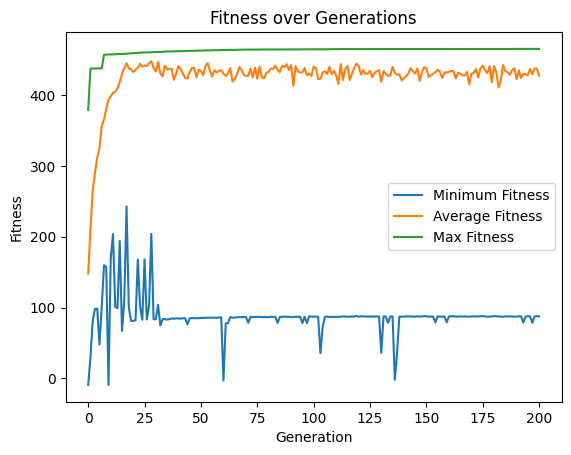

In [25]:
import random
import numpy as np

# set up the GA parameters
POPULATION_SIZE = 200
P_CROSSOVER = 0.8  # probability for crossover
P_MUTATION = 0.2   # probability for mutation
MAX_GENERATIONS = 200
HALL_OF_FAME_SIZE = 5

# set the random seed for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

# set up the DEAP toolbox with the necessary elements
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize the DEAP toolbox
toolbox = base.Toolbox()

# Define the operators
toolbox.register("attributes", random.randint, -1, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attributes, n=PLACES*TRANSITIONS)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Initialize statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

# Initialize the hall of fame
hall_of_fame = tools.HallOfFame(HALL_OF_FAME_SIZE)

# Run the GA
pop = toolbox.population(n=POPULATION_SIZE)
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                   ngen=MAX_GENERATIONS, stats=stats, halloffame=hall_of_fame, verbose=True)

# Get the best individual
best_individual = hall_of_fame[0]
best_fitness = best_individual.fitness.values[0]
print("Best individual:", best_individual)
print("Best fitness:", best_fitness)

# Plot the evolution of the fitness across generations
import matplotlib.pyplot as plt
gen, min_fit, avg_fit, max_fit = logbook.select("gen", "min", "avg", "max")
plt.plot(gen, min_fit, label="Minimum Fitness")
plt.plot(gen, avg_fit, label="Average Fitness")
plt.plot(gen, max_fit, label="Max Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.show()

